In [1]:
# coding=utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix,precision_recall_curve,average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn import preprocessing
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
import keras.backend as K
from pandas import Series, DataFrame
import seaborn as sns
sns.set()

def draw_roc_and_calculate_auc(models, modelnames, colors, X_test, y_test):  # 把models的roc曲线(和auc值)画到一张图
    N = len(models)  # 输入的是N个模型
    y_test_pred_prob = [0] * N  # 初始化一下列表（感觉这么初始化有点丑？）
    auc = [0] * N
    FPR = [0] * N
    TPR = [0] * N
    plt.figure()
    for i in range(N):
        y_test_pred_prob[i] = models[i].predict(X_test)
        auc[i] = roc_auc_score(y_test, y_test_pred_prob[i], average='macro')
        FPR[i], TPR[i], _ = roc_curve(y_test, y_test_pred_prob[i])
        plt.plot(FPR[i], TPR[i], color=colors[i], label=modelnames[i] + ':AUC=%.4f' % auc[i])
    plt.plot([0, 1], [0, 1], '--', color='black')  # diagonal line
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
def draw_pr_and_calculate_ap(models, modelnames, colors, X_test, y_test):  # 把models的roc曲线(和auc值)画到一张图
    N = len(models)  # 输入的是N个模型
    y_test_pred_prob = [0] * N  # 初始化一下列表（感觉这么初始化有点丑？）
    AP = [0] * N
    Precision = [0] * N
    Recall = [0] * N
    plt.figure()
    for i in range(N):
        y_test_pred_prob[i] = models[i].predict(X_test)
        AP[i] = average_precision_score(y_test, y_test_pred_prob[i], average='macro')
        Precision[i], Recall[i], _ = precision_recall_curve(y_test, y_test_pred_prob[i])
        plt.plot(Precision[i], Recall[i], color=colors[i], label=modelnames[i] + ':AP=%.4f' % AP[i])
    plt.plot([0, 1], [1, 0], '--', color='black')  # diagonal line
    plt.title('PR Curve')
    plt.legend(loc='lower right')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.show()


def draw_confusion_metrics(model, modelname, X_test, y_test):  # 把model的混淆矩阵画出来  #这个同时写很多的话不知道怎么安排画布就没写sos
    plt.figure()

    y_test_pred=(model.predict(X_test) >= 0.5).astype("int32")

    # # y_test_pred = model.predict(X_test)  # 上面那行有时候会报错，如果模型直接是classifier用这行就行
    # y_test_pred = model.predict_proba(X_test)[:, 1]  # 取第二列 正的概率，根据每个人的数据不同而不同!
    # y_test_pred = np.around(y_test_pred, 0).astype(int)

    c_matrix = confusion_matrix(y_test, y_test_pred)
    ax = sns.heatmap(c_matrix, annot=True, fmt="d",
                     xticklabels=['0', '1'],
                     yticklabels=['0', '1'],  # 应该没写反吧
                     cbar=False, cmap='Blues')
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Actual")
    plt.title(modelname)
    plt.show()


plt.rcParams.update({'figure.autolayout': True})

####导入数据
df = pd.read_csv("E:/Desktop/train_after_FeatureEngineer.csv")

df_X = df.drop(['target', 'id'], axis=1)
X = df_X.loc[:, :]
Y = df.loc[:, 'target']
X = X.to_numpy()
y = Y.to_numpy()

####导入数据
df = pd.read_csv("E:/Desktop/train_after_FeatureEngineer.csv")

df_X=df.drop(['target','id'],axis=1)
X=df_X.loc[:,:]
Y=df.loc[:,'target']
X=X.to_numpy()
y=Y.to_numpy()

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2,random_state=123)


In [2]:
''' focal loss '''
def binary_focal_loss(alpha, gamma):
    alpha = tf.constant(alpha, dtype=tf.float32)
    gamma = tf.constant(gamma, dtype=tf.float32)

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        y_true shape need be (None,1)
        y_pred need be compute after sigmoid
        """
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)

        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (K.ones_like(y_true) - y_pred) + K.epsilon()
        focal_loss = - alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        focal_loss=focal_loss*10
        return K.mean(focal_loss,axis=-1)

    return binary_focal_loss_fixed

In [3]:
# building the nn
model1 = Sequential()
# model1.add(Dense(20, activation='relu', input_dim=58))
# model1.add(Dense(16, activation='relu'))
# model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

# building the nn
model2 = Sequential()
# model2.add(Dense(20, activation='relu', input_dim=58))
# model2.add(Dense(16, activation='relu'))
# model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))


# building the nn
model3 = Sequential()
# model3.add(Dense(20, activation='relu', input_dim=58))
# model3.add(Dense(16, activation='relu'))
# model3.add(Dense(8, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))


# building the nn
model4 = Sequential()
# model4.add(Dense(20, activation='relu', input_dim=58))
# model4.add(Dense(16, activation='relu'))
# model4.add(Dense(8, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))


# building the nn
model5 = Sequential()
# model5.add(Dense(20, activation='relu', input_dim=58))
# model5.add(Dense(16, activation='relu'))
# model5.add(Dense(8, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))

In [4]:
print("---------no focal loss-----------")
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['mae','binary_accuracy'])
# fit
model1.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

---------no focal loss-----------
Epoch 1/5
3721/3721 [==============================] - 47s 12ms/step - loss: 0.3826 - mae: 0.0957 - binary_accuracy: 0.9378 - val_loss: 0.1611 - val_mae: 0.0644 - val_binary_accuracy: 0.9635
Epoch 2/5
3721/3721 [==============================] - 44s 12ms/step - loss: 0.1569 - mae: 0.0702 - binary_accuracy: 0.9637 - val_loss: 0.1556 - val_mae: 0.0678 - val_binary_accuracy: 0.9635
Epoch 3/5
3721/3721 [==============================] - 37s 10ms/step - loss: 0.1555 - mae: 0.0700 - binary_accuracy: 0.9637 - val_loss: 0.1569 - val_mae: 0.0817 - val_binary_accuracy: 0.9635
Epoch 4/5
3721/3721 [==============================] - 46s 12ms/step - loss: 0.1553 - mae: 0.0700 - binary_accuracy: 0.9637 - val_loss: 0.1561 - val_mae: 0.0788 - val_binary_accuracy: 0.9635
Epoch 5/5
3721/3721 [==============================] - 48s 13ms/step - loss: 0.1552 - mae: 0.0702 - binary_accuracy: 0.9637 - val_loss: 0.1550 - val_mae: 0.0664 - val_binary_accuracy: 0.9635


In [5]:
focal_loss0=binary_focal_loss(alpha=0.5, gamma=0)
focal_loss1=binary_focal_loss(alpha=0.95, gamma=0)
focal_loss2=binary_focal_loss(alpha=0.95, gamma=2)
focal_loss3=binary_focal_loss(alpha=0.95, gamma=4)

In [6]:
print("---------focal loss: alpha=0.5,gamma=0-----------")
model2.compile(optimizer='adam',
               loss=focal_loss0,
               metrics=['mae','binary_accuracy'])
model2.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

print("---------focal loss: alpha=0.95,gamma=0-----------")
model3.compile(optimizer='adam',
               loss=focal_loss1,
               metrics=['mae','binary_accuracy'])
model3.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


print("---------focal loss: alpha=0.95,gamma=2-----------")
model4.compile(optimizer='adam',
               loss=focal_loss2,
               metrics=['mae','binary_accuracy'])
model4.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

print("---------focal loss: alpha=0.95,gamma=4-----------")
model5.compile(optimizer='adam',
               loss=focal_loss3,
               metrics=['mae','binary_accuracy'])
model5.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

---------focal loss: alpha=0.5,gamma=0-----------
Epoch 1/5
3721/3721 [==============================] - 49s 13ms/step - loss: nan - mae: nan - binary_accuracy: 0.9618 - val_loss: nan - val_mae: nan - val_binary_accuracy: 0.9635
Epoch 2/5
3721/3721 [==============================] - 43s 11ms/step - loss: nan - mae: nan - binary_accuracy: 0.9637 - val_loss: nan - val_mae: nan - val_binary_accuracy: 0.9635
Epoch 3/5
3721/3721 [==============================] - 42s 11ms/step - loss: nan - mae: nan - binary_accuracy: 0.9637 - val_loss: nan - val_mae: nan - val_binary_accuracy: 0.9635
Epoch 4/5
3721/3721 [==============================] - 49s 13ms/step - loss: nan - mae: nan - binary_accuracy: 0.9637 - val_loss: nan - val_mae: nan - val_binary_accuracy: 0.9635
Epoch 5/5
3721/3721 [==============================] - 40s 11ms/step - loss: nan - mae: nan - binary_accuracy: 0.9637 - val_loss: nan - val_mae: nan - val_binary_accuracy: 0.9635
---------focal loss: alpha=0.95,gamma=0-----------
Epoc

In [11]:
# building the nn
model6 = Sequential()
# model5.add(Dense(20, activation='relu', input_dim=58))
# model5.add(Dense(16, activation='relu'))
# model5.add(Dense(8, activation='relu'))
model6.add(Dense(1, activation='sigmoid'))

focal_loss4=binary_focal_loss(alpha=0.95, gamma=8)
print("---------focal loss: alpha=0.95,gamma=8-----------")
model6.compile(optimizer='adam',
               loss=focal_loss4,
               metrics=['mae','binary_accuracy'])
model6.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

---------focal loss: alpha=0.95,gamma=8-----------
Epoch 1/5
3721/3721 [==============================] - 38s 10ms/step - loss: 0.2163 - mae: 0.4758 - binary_accuracy: 0.5547 - val_loss: 0.0036 - val_mae: 0.4907 - val_binary_accuracy: 0.5600
Epoch 2/5
3721/3721 [==============================] - 37s 10ms/step - loss: 0.0026 - mae: 0.4886 - binary_accuracy: 0.6453 - val_loss: 0.0027 - val_mae: 0.5209 - val_binary_accuracy: 0.0952
Epoch 3/5
3721/3721 [==============================] - 38s 10ms/step - loss: 0.0024 - mae: 0.4880 - binary_accuracy: 0.6842 - val_loss: 0.0027 - val_mae: 0.5211 - val_binary_accuracy: 0.0928
Epoch 4/5
3721/3721 [==============================] - 40s 11ms/step - loss: 0.0024 - mae: 0.4878 - binary_accuracy: 0.6745 - val_loss: 0.0022 - val_mae: 0.4916 - val_binary_accuracy: 0.6994
Epoch 5/5
3721/3721 [==============================] - 36s 10ms/step - loss: 0.0024 - mae: 0.4881 - binary_accuracy: 0.6820 - val_loss: 0.0025 - val_mae: 0.5133 - val_binary_accuracy: 0

14881/14881 [==============================] - 47s 3ms/step


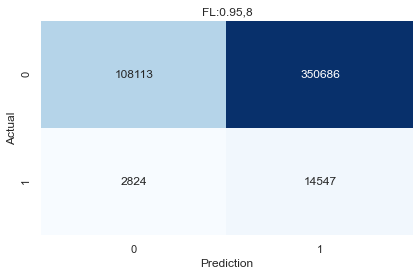

In [21]:
draw_confusion_metrics(model=model6,modelname='FL:0.95,8',X_test=X_test,y_test=y_test)

#### 上图说明，gamma过大会导致另一种错分

---------focal loss: alpha=0.85,gamma=4-----------
Epoch 1/5
3721/3721 [==============================] - 37s 10ms/step - loss: 0.0549 - mae: 0.4204 - binary_accuracy: 0.9637 - val_loss: 0.0550 - val_mae: 0.4271 - val_binary_accuracy: 0.9635
Epoch 2/5
3721/3721 [==============================] - 36s 10ms/step - loss: 0.0548 - mae: 0.4229 - binary_accuracy: 0.9637 - val_loss: 0.0549 - val_mae: 0.4200 - val_binary_accuracy: 0.9635
Epoch 3/5
3721/3721 [==============================] - 44s 12ms/step - loss: 0.0548 - mae: 0.4225 - binary_accuracy: 0.9637 - val_loss: 0.0550 - val_mae: 0.4286 - val_binary_accuracy: 0.9635
Epoch 4/5
3721/3721 [==============================] - 40s 11ms/step - loss: 0.0548 - mae: 0.4229 - binary_accuracy: 0.9637 - val_loss: 0.0549 - val_mae: 0.4223 - val_binary_accuracy: 0.9635
Epoch 5/5
14881/14881 [==============================] - 30s 2ms/step


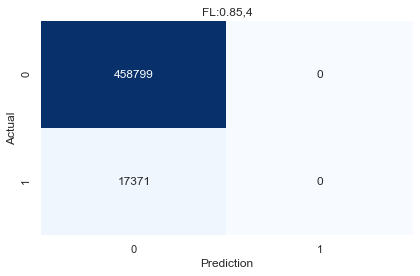

In [24]:
# building the nn
model = Sequential()
# model5.add(Dense(20, activation='relu', input_dim=58))
# model5.add(Dense(16, activation='relu'))
# model5.add(Dense(8, activation='relu'))
model7.add(Dense(1, activation='sigmoid'))

focal_loss5=binary_focal_loss(alpha=0.85, gamma=4)
print("---------focal loss: alpha=0.85,gamma=4-----------")
model7.compile(optimizer='adam',
               loss=focal_loss5,
               metrics=['mae','binary_accuracy'])
model7.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

draw_confusion_metrics(model=model7,modelname='FL:0.85,4',X_test=X_test,y_test=y_test)

14881/14881 [==============================] - 23s 2ms/step


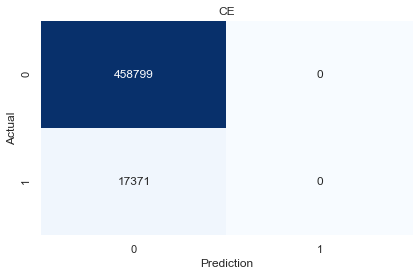

14881/14881 [==============================] - 26s 2ms/step


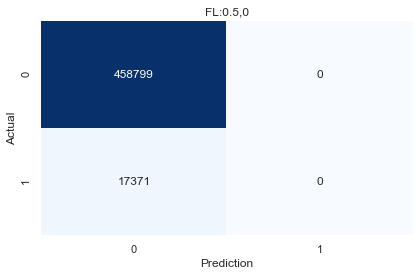

14881/14881 [==============================] - 27s 2ms/step


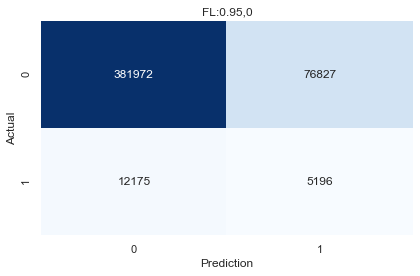

14881/14881 [==============================] - 25s 2ms/step


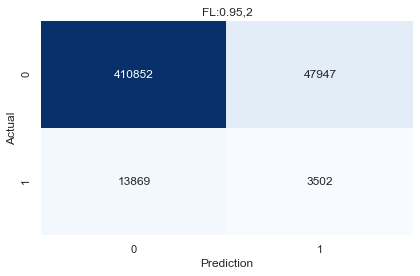

14881/14881 [==============================] - 30s 2ms/step


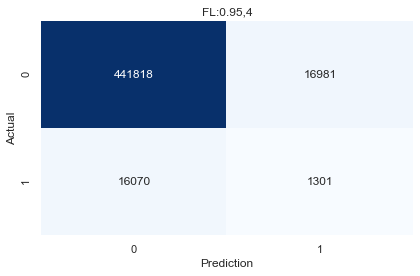

14881/14881 [==============================] - 46s 3ms/step


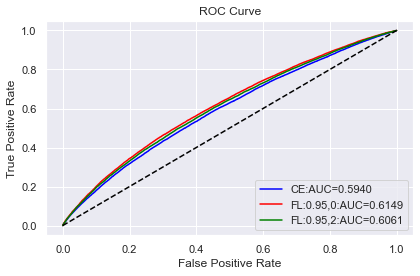

In [20]:
# #
# draw_confusion_metrics(model=model1,modelname='MLP',X_test=X_test,y_test=y_test)
# draw_confusion_metrics(model=model2,modelname='MLP with focal loss',X_test=X_test,y_test=y_test)

models=[model1,model2,model3,model4,model5]
modelnames=['CE','FL:0.5,0','FL:0.95,0','FL:0.95,2','FL:0.95,4']
for i,model in enumerate(models):
    draw_confusion_metrics(model=models[i],modelname=modelnames[i],X_test=X_test,y_test=y_test)
    

#
draw_roc_and_calculate_auc(models=[model1,model3,model4],modelnames=['CE','FL:0.95,0','FL:0.95,2'],colors=['blue','red','green'],X_test=X_test,y_test=y_test)
